## Targeted Iterative Assembly (TIA)
Code developed by Marcelo Prado Cionek from the Federal University of Paraná, Brazil.
Public version made available for the paper 'Targeted iterative assembly and the midpoint method for improved convergence in point-by-point algorithms for freeform generation' by M. Cionek and E. C. Barbano in Optics Continuum.
<br><br>
The **Targeted Iterative Assembly** (**TIA**) is a point-by-point method to generate lenses with prescribed input-output variables via the trigonometric relation:
$\theta_{out} = \arctan\left(\dfrac{T_y-V_y}{T_x-V_x}\right)$.
<br>
Where $T_x$ and $T_y$ are functions of (potentially) all the system's variables and the step variable $i$. The 'stype' and 'Ttype' parameters allow changing between TIA and the **Angular Iterative Assembly** (**AIA**), where output angles are controlled instead of the spatial target.  
<br><br>
Here, $N_S$ Multiple surfaces can be generated in succession, with independent targets (**Sequential Iterative Assembly** or **SIA**) or with coupled vertexes (**Coupled Iterative Assembly** or **CIA**). You can change the solution type with the 'surface_generation' parameter. The targets and initial conditions are written up to the second surface, but you can manually insert the necessary subsequent definitions. Pay attention to the comments indicating how each function is related to each configuration of the system.
<br><br>
You can set the solutions to be calculated with the Direct mode (first order, linear iterator) or the Midpoint modes 1A and 3A (predictor-corrector, transcendental iterator, currently unavailable to CIA). The Midpoint method generates *$2 N_R$* vertexes, where the midpoints (coordinates of ray incidence) are associated with even indices (starting at 0) and the corners (coordinates where the slope changes) to the odd indices. It must be noted mode 1A generates 'current midpoint, next corner' while 3A generates 'previous corner, current midpoint' due to the nature of their equations.
<br><br>
While adjusting the initial parameters and functions, use only a few dozen rays to save time. With $N_R > 10^3$, sub-micrometric precision can be achieved with the midpoint methods. You can also export the raw vertex data, and all the relevant positions of the system.
<br><br>
Contact: marcelo.cionek@ufpr.br (Please indicate TIA in the subject if related)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy import special

In [6]:
time_start = time.time()

'Assembly Settings'
NS = 2 # Number of surfaces
NR = 2000 #Number of rays
surface_generation = 0 #Set 0 for Sequential, 1 for Coupled
if surface_generation == 1:
    ctype = [0]*NS #0 for transversal, 1 for parallel
    ctype = [1,1] #Use cytpes = [0,0,1,...] if coupling type varies;
    Ttype = 1 #Target type. 0 for spatial, 1 for angular
else:
    stype = [1]*NS #0 for spatial target, 1 for angular
    stype = [1,0] #Use stypes = [1,0,1...] if target type varies;
ray_ordering = False #Check current order of rays in every iteration
dir_order = [0]*NS #0 to reorder variables following the crescent order in y-axis; 1 for decrescent.
ordt = int(np.floor(NR/20)) #order_threshold
midpoint = True if surface_generation == 0 else False
mp_mode = 1 if midpoint == True else 0 # 1 for 1A. 2 for 3A
itr = 2 #Number of iterations to solve transcendental equations
initvert = True #True if inital ray is unaltered, thus the firssegments are vertical
if initvert == True:
    w1, w2 = 1, 1 #Weights for averaging VY_0 and VY_1 in Midpoint 1A
else:
    w1, w2 = 1, 0
W = w1 + w2

'Initial Distribution'
#Due to Python 53-bit limit, it struggles to handle calculations with values below e-15
#Avoid using exact zeros that might lead to perfectly vertical slopes.

x_0, x_f = 0, 0
y_0, y_f = 1e-12, 1e-12
theta_0, theta_f = 1e-11, np.pi/4
sysor = np.sign(theta_f-theta_0)

x_in = np.linspace(x_0, x_f, NR)
y_in = np.linspace(y_0, y_f, NR)
theta_in = np.linspace(theta_0, theta_f, NR)

'Lens properties'
n = [1]*(NS+1)
singlemat = False #All lens interiors are made of the same material.
if singlemat == True:
    nmat = 1.5
    for i in range(NS+1):
        if i % 2 == 0: # If i is even
            n[i] = 1 # For source in air
            #n[i] = nmat #For source in lens
        else: # If i is odd
            n[i] = nmat  # For source in air
            #n[i] = nmat #For source in lens
else: #Manually set the index of refraction for the NS+1 material media
    n[0] = 1
    n[1] = 1.5
    n[2] = 1

'Geometric functions'
def r(x, X, Y, theta): #Ray equation
    return np.tan(theta) * (x - X) + Y

def s(x, vx, vy, tN): #Segment equation
    return -1/np.tan(tN) * (x - vx) + vy

def Sni(theta_in, theta_out, n): #Calculate surface angle from inverse refraction law
#    return np.arctan2(np.sin(theta_in)-n*np.sin(theta_out),np.cos(theta_in)-n*np.cos(theta_out))
    return np.arctan((np.sin(theta_in)-n*np.sin(theta_out))/(np.cos(theta_in)-n*np.cos(theta_out)))

'Initial vertexes and target functions'
F = 0.25 #Focal length
w = 0.000025 #Beam waist
b = 0#np.pi/8 #Beam direction
S = 1*sysor #Sign of aberration

VX_0, VY_0 = [0]*NS, [0]*NS
VX_0[0], VX_0[1] = F, 2 #Definitions are in general arbitrary

tt_set = []
if surface_generation == 0: #Target functions must be defined for each surface in sequential mode
    if stype[0] == 0: #Spatial target of the first surface
        def x_t1(x,y,t,i):
            return VX_0[0]+0.5+np.sin(2*i*np.pi/NR)/10
        def y_t1(x,y,t,i):
            return 1*i/NR
        tt_set.append(0)

    else: #Angular target
        def theta_o1(x,y,t,i): #Define your angular target function of the first surface
            return t*0.00000001
        def x_t1(x,y,t,i):
            return x+np.cos(theta_o1(x,y,t,i))
        def y_t1(x,y,t,i):
            return y+np.sin(theta_o1(x,y,t,i))
        tt_set.append(theta_o1)

    if stype[1] == 0: #Spatial target of the second surface
        def x_t2(x,y,t,i):
            return VX_0[-1]+F*np.cos(b)-S*w*(i/(NR-1))**8*np.sin(b)
        def y_t2(x,y,t,i):
            return VY_0[-1]+F*np.sin(b)+S*w*(i/(NR-1))**8*np.cos(b)
        tt_set.append(0)

    else: #Angular target
        def theta_o2(x,y,t,i): #Define your angular target function
            return np.arctan2(VY_0[-1]+F*np.sin(b)-y+S*w*(i/(NR-1))**3*np.cos(b),VX_0[-1]+F*np.cos(b)-x-S*w*(i/(NR-1))**3*np.sin(b))
        def x_t2(x,y,t,i):
            return x+2*np.cos(theta_o2(x,y,t,i))
        def y_t2(x,y,t,i):
            return y+2*np.sin(theta_o2(x,y,t,i))
        tt_set.append(theta_o2)
    #Put all the functions in a list
    xt_set = [x_t1, x_t2]
    yt_set = [y_t1, y_t2]
else:  #In coupled mode, only parallel/transversal distributions are chosen, with a final target
#Only one of the target functions will be used per surface, based on its ctype value.
    def x_t1(x,y,t,i):
        return 2*x+0.5*i/NR
    def y_t1(x,y,t,i):
        L = 0.7
        k = 0.5
        return L*special.erfi(i/((NR-1)*k)) / special.erfi(1/(k))
    if ctype[1] == 0:
        VY_0[1] = y_t1(x_in[0],y_in[0],theta_in[0],0)
    else:
        VX_0[1] = x_t1(x_in[0],y_in[0],theta_in[0],0)
#Fill with missing target functions if NS>2
    if Ttype == 0: #Spatial final target
        def Tx(x,y,t,i): #Final target X coordinate
            return 2+0.05*i/NR
        def Ty(x,y,t,i): #Final target Y coordinate
            return i**2/NR**2*0.03
    else: #Angular target:
        def theta_oT(t,i): #Angular final target
            return 0.0
        def Tx(x,y,t,i): #Final target X coordinate
            return x+3*np.cos(theta_oT(t,i))
        def Ty(x,y,t,i): #Final target Y coordinate
            return y+3*np.sin(theta_oT(t,i))
    t_set =[[y_t1,x_t1]] #Array of pairs of possible distributions

#Write the X coordinate of the initial vertex of the NS surfaces
VY_0[0] = r(VX_0[0], x_in[0],y_in[0],theta_in[0])
VY_0[1] = 0#r(VX_0[1], VX_0[0],VY_0[0],theta_out_0[0])
#If more surfaces are present, fill the missing initial variables
if surface_generation == 0: #Force correct the VY coordinates if angular mode is active
    Xa = [x_in[0]]
    Ya = [y_in[0]]
    Xa.extend(VX_0)
    Ya.extend(VY_0)
    theta_0_angular=[theta_in[0]]
    for s in range(1,NS):
        if stype[s-1] == 1:
            theta_i = np.arctan2(Ya[s]-Ya[s-1],Xa[s]-Xa[s-1])
            theta_0_angular.append(tt_set[s-1](VX_0[s],VY_0[s],theta_i,0))
            VY_0[s] = r(VX_0[s],VX_0[s-1],VY_0[s-1],theta_0_angular[-1])
        else:
            theta_0_angular.append(0)
        theta_0_angular.append(tt_set[s-1](VX_0[-1],VY_0[-1],theta_0_angular[-1],0))

#Just keep the manually defined coordinates if mode is not angular and set a dummy angle for that slot
else:
    for s in range(1,NS):
        if ctype[s-1] == 0:
            VY_0[s] = t_set[s-1][ctype[s-1]](x_in[0],y_in[0],theta_in[0],0)
        else:
            VX_0[s] = t_set[s-1][ctype[s-1]](x_in[0],y_in[0],theta_in[0],0)

b = theta_0_angular[-1] #For beam waist

time_set = time.time()
print("Time to set up system",time_set-time_start,"seconds")

Time to set up system 0.005496025085449219 seconds


In [7]:
'Initialize General Matrices' #All positions, all vertexes
X = []
X.append(list(x_in))
Y = []
Y.append(list(y_in))
theta = []
theta.append(list(theta_in))

def split(arr): #To split corners and midpoints
    ID_mid = []
    ID_cor = []
    for i in range(len(arr)):
        if i % 2 == 0:
            ID_mid.append(arr[i])
        else:
            ID_cor.append(arr[i])
    return ID_mid, ID_cor

def SIA_Direct():
    VX, VY = [], [] #Initialize vertex set
    xT, yT = [], []
    theta_outs = [] #Initialize output angles set
    for s in range(0,NS):
        VXs, VYs = [], [] #Current vertex set
        xTs, yTs = [], []
        tOs = [] #Current output angles
        VXs.append(VX_0[s]) #Append initial vertex
        VYs.append(VY_0[s])
        if stype[s] == 0: #Spatial target
            xTs.append(xt_set[s](x_in[0],y_in[0],theta_in[0],0))
            yTs.append(yt_set[s](x_in[0],y_in[0],theta_in[0],0))
            tOs.append(np.arctan2(yTs[0]-VYs[0],xTs[0]-VXs[0]))
        else: #Angular target MUST use current vertexes
            xTs.append(xt_set[s](VX_0[s],VY_0[s],theta_0_angular[s+1],0))
            yTs.append(yt_set[s](VX_0[s],VY_0[s],theta_0_angular[s+1],0))
            tOs.append(theta_0_angular[s+1])
        if ray_ordering == False: #Run normal algorithm
            for i in range(0,NR-1):
                tI2 = np.tan(theta[s][i+1])
                tN = 1/np.tan(Sni(theta[s][i],tOs[-1],n[s+1]/n[s]))
                VX2num = VYs[-1]-Y[s][i+1] + tI2 * X[s][i+1] + VXs[-1]*tN
                VX2D = VX2num / (tI2 + tN)
                VY2D = -tN*(VX2D - VXs[-1]) + VYs[-1]
                VXs.append(VX2D)
                VYs.append(VY2D)
                if stype[s] == 0: #Spatial target
                    yTs.append(yt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1))
                    xTs.append(xt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1))
                    tOs.append(np.arctan2(yTs[-1]-VYs[-1],xTs[-1]-VXs[-1]))
                else: #Angular target MUST use current vertexes
                    tOs.append(tt_set[s](VXs[-1],VYs[-1],theta[s][i+1],i+1))
                    xTs.append(xt_set[s](VXs[-1],VYs[-1],tOs[-1],i+1))
                    yTs.append(yt_set[s](VXs[-1],VYs[-1],tOs[-1],i+1))
            else: #Check ray ordering every iteration
                pass
        #Append NR-sized arrays for each of the NS surfaces
        VX.append(VXs)
        VY.append(VYs)
        X.append(VXs)
        Y.append(VYs)
        xT.append(xTs)
        yT.append(yTs)
        theta_outs.append(tOs)
        theta.extend(theta_outs)
    X.append(xT[-1])
    Y.append(yT[-1])
    return VX, VY, theta_outs, xT, yT

def SIA_1A():
    VX, VY = [], [] #Initialize vertex set
    xT, yT = [], []
    theta_outs = [] #Initialize output angles set
    for s in range(0,NS):
        VXs, VYs = [], [] #Current vertex set
        xTs, yTs = [], []
        tOs = [] #Current output angles
        VXs.append(VX_0[s]) #Append initial vertex
        VYs.append(VY_0[s])
        C = (w1*VY_0[s]+w2*r(VX_0[s], X[s][1], Y[s][1], theta[s][1]))/W
        VXs.append(VX_0[s]+C*np.sin(theta[s][0])) #Append initial corner
        VYs.append(C*np.cos(theta[s][0]))
        if stype[s] == 0: #Spatial target
            xTs.append(xt_set[s](x_in[0],y_in[0],theta_in[0],0))
            yTs.append(yt_set[s](x_in[0],y_in[0],theta_in[0],0))
            tOs.append(np.arctan2(yTs[0]-VYs[0],xTs[0]-VXs[0]))
        else: #Angular target MUST use current vertexes
            xTs.append(xt_set[s](VX_0[s],VY_0[s],theta_0_angular[s+1],0))
            yTs.append(yt_set[s](VX_0[s],VY_0[s],theta_0_angular[s+1],0))
            tOs.append(theta_0_angular[s+1])
        if ray_ordering == False: #Run normal algorithm
            tN = 1/np.tan(Sni(theta[s][0],tOs[0],n[s+1]/n[s]))
            for i in range(0,NR-1):
                tI2 = np.tan(theta[s][i+1])
            #First, calculate V2 via direct method. This will be used as initial guess for V2m
                VX2num = VYs[2*i+1]-Y[s][i+1] + tI2 * X[s][i+1] + VXs[2*i+1]*tN
                VX2D = VX2num / (tI2 + tN)
                VY2D = tI2 * (VX2D - X[s][i+1]) + Y[s][i+1]
                if i < NR-2: #Use midpoint except for last vertex
                    VX2 = VX2D
                    for j in range(0, itr): #Solve transcendental equation iteratively
                        VY2 = tI2 * (VX2 - X[s][i+1]) + Y[s][i+1]
                        if stype[s] == 0: #Spatial target
                            tx = xt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                            ty = yt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                            theta_out2 = np.arctan2(ty-VY2,tx-VX2)
                        else: #Angular target MUST use current vertexes
                            theta_out2 = tt_set[s](VX2,VY2,theta[s][i+1],i+1)
                            tx = xt_set[s](VX2,VY2,theta_out2,i+1)
                            ty = yt_set[s](VX2,VY2,theta_out2,i+1)
                        tN2 = 1/np.tan(Sni(theta[s][i+1], theta_out2, n[s+1]/n[s]))
                        VX2=(Y[s][i+1]-VYs[2*i+1]-tN2*VXs[2*i+1]-tI2*X[s][i+1])/(-tN2-tI2)
                    tOs.append(theta_out2)
                    #Intercept with next ray to get midpoint
                    tI3 = np.tan(theta[s][i+2])
                    VX3num = VY2-Y[s][i+2] + tI3*X[s][i+2] + VX2*tN2
                    VX3D = VX3num / (tI3 + tN2)
                    VX2c = (VX3D+VX2)/2
                    VY2c = -tN2*(VX2c-VX2)+VY2
                    VXs.append(VX2)
                    VYs.append(VY2)
                    VXs.append(VX2c)
                    VYs.append(VY2c)
                    tOs.append(theta_out2)
                    tN = tN2 #Make the current normal be the next initial normal
                else: #Apply direct method for the last
                    VXmid = (VX2D+VXs[2*i+1])/2
                    VYmid = -tN*(VXmid-VXs[-1])+VYs[-1]
                    VXs.append(VX2D)
                    VYs.append(VY2D)
                    VXs.append(VX2D)
                    VYs.append(VY2D)
                    if stype[s] == 0: #Spatial target
                        tx = xt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                        ty = yt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                        theta_out2 = np.arctan2(ty-VY2,tx-VX2)
                    else: #Angular target MUST use current vertexes
                        theta_out2 = tt_set[s](VX2,VY2,theta[s][i+1],i+1)
                        tx = xt_set[s](VX2,VY2,theta_out2,i+1)
                        ty = yt_set[s](VX2,VY2,theta_out2,i+1)
                xTs.append(tx)
                yTs.append(ty)
            else: #Check ray ordering every iteration
                pass
        #Append NR-sized arrays for each of the NS surfaces
        VX.append(VXs)
        VY.append(VYs)
        VXM, VXC = split(VXs)
        VYM, VYC = split(VYs)
        X.append(VXM) #Append only the midpoints to the position matrix
        Y.append(VYM)
        xT.append(xTs)
        yT.append(yTs)
        theta_outs.append(tOs)
        theta.extend(theta_outs)
    X.append(xT[-1])
    Y.append(yT[-1])
    return VX, VY, theta_outs, xT, yT

def SIA_3A():
    VX, VY = [], [] #Initialize vertex set
    xT, yT = [], []
    theta_outs = [] #Initialize output angles set
    for s in range(0,NS):
        VXs, VYs = [], [] #Current vertex set
        xTs, yTs = [], []
        tOs = [] #Current output angles
        VXs.append(VX_0[s]) #Append initial vertex
        VYs.append(VY_0[s])
        if stype[s] == 0: #Spatial target
            xTs.append(xt_set[s](x_in[0],y_in[0],theta_in[0],0))
            yTs.append(yt_set[s](x_in[0],y_in[0],theta_in[0],0))
            tOs.append(np.arctan2(yTs[0]-VYs[0],xTs[0]-VXs[0]))
        else: #Angular target MUST use current vertexes
            xTs.append(xt_set[s](VX_0[s],VY_0[s],theta_0_angular[s+1],0))
            yTs.append(yt_set[s](VX_0[s],VY_0[s],theta_0_angular[s+1],0))
            tOs.append(theta_0_angular[s+1])
        if ray_ordering == False: #Run normal algorithm
            tN = 1/np.tan(Sni(theta[s][0],tOs[0],n[s+1]/n[s]))
            for i in range(0,NR-1):
                tI2 = np.tan(theta[s][i+1])
            #First, calculate V2 via direct method. This will be used as initial guess for V2m
                VX2num = VYs[2*i]-Y[s][i+1] + tI2 * X[s][i+1] + VXs[2*i]*tN
                VX2D = VX2num / (tI2 + tN)
                VY2D = tI2 * (VX2D - X[s][i+1]) + Y[s][i+1]
                if i < NR-2: #Use midpoint except for last vertex
                    VX2 = VX2D
                    for j in range(0, itr): #Solve transcendental equation iteratively
                        #M = (VX2D+VXs[2*i])/2
                        VY2 = tI2 * (VX2 - X[s][i+1]) + Y[s][i+1]
                        if stype[s] == 0: #Spatial target
                            tx = xt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                            ty = yt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                            theta_out2 = np.arctan2(ty-VY2,tx-VX2)
                        else: #Angular target MUST use current vertexes
                            theta_out2 = tt_set[s](VX2,VY2,theta[s][i+1],i+1)
                            tx = xt_set[s](VX2,VY2,theta_out2,i+1)
                            ty = yt_set[s](VX2,VY2,theta_out2,i+1)
                        #N_angle = Sni(theta[s][i+1], theta_out2, n[s+1]/n[s])
                        tN2 = 1/np.tan(Sni(theta[s][i+1], theta_out2, n[s+1]/n[s]))
                        VX2 = (2*(Y[s][i+1]-VYs[2*i]-tI2*X[s][i+1])-VXs[2*i]*(tN+tN2))/(-tN-tN2-2*tI2)
                    tOs.append(theta_out2)
                    VXc = (VX2+VXs[2*i])/2
                    VYc = -tN2*(VXc-VX2)+VY2
                    VXs.append(VXc)
                    VYs.append(VYc)
                    VXs.append(VX2)
                    VYs.append(VY2)
                    tOs.append(theta_out2)
                    tN = tN2 #Make the current normal be the next initial normal
                else: #Apply direct method for the last
                    VXmid = (VX2D+VXs[2*i])/2
                    VYmid = -tN*(VXmid-VXs[-1])+VYs[-1]
                    VXs.append(VXmid)
                    VYs.append(VYmid)
                    VXs.append(VX2D)
                    VYs.append(VY2D)
                    VXs.append(VX2D) #Consider the last point as a corner too so the number of midpoints and corners is equal
                    VYs.append(VY2D)
                    if stype[s] == 0: #Spatial target
                        tx = xt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                        ty = yt_set[s](X[s][i+1],Y[s][i+1],theta[s][i],i+1)
                        theta_out2 = np.arctan2(ty-VY2,tx-VX2)
                    else: #Angular target MUST use current vertexes
                        theta_out2 = tt_set[s](VX2,VY2,theta[s][i+1],i+1)
                        tx = xt_set[s](VX2,VY2,theta_out2,i+1)
                        ty = yt_set[s](VX2,VY2,theta_out2,i+1)
                xTs.append(tx)
                yTs.append(ty)
            else: #Check ray ordering every iteration
                pass
        #Append NR-sized arrays for each of the NS surfaces
        VX.append(VXs)
        VY.append(VYs)
        VXM, VXC = split(VXs)
        VYM, VYC = split(VYs)
        X.append(VXM) #Append only the midpoints to the position matrix
        Y.append(VYM)
        xT.append(xTs)
        yT.append(yTs)
        theta_outs.append(tOs)
        theta.extend(theta_outs)
    X.append(xT[-1])
    Y.append(yT[-1])
    return VX, VY, theta_outs, xT, yT

def CIA():
    VX, VY = [], []
    if Ttype == 0:
        VX_0.append(Tx(x_in[0],y_in[0],theta_in[0],0))
        VY_0.append(Ty(x_in[0],y_in[0],theta_in[0],0))
    else: #If angular, must depend on last vertex
        theta_last = np.arctan2(VY_0[-1]-VY_0[-2],VX_0[-1]-VX_0[-2])
        VX_0.append(Tx(VX_0[-1],VY_0[-1],theta_in[0],0))
        VY_0.append(Ty(x_in[0],y_in[0],theta_in[0],0))

    VX.append(VX_0)
    VY.append(VY_0) #The first row of the initial vertexes are the initial vertexes themselves
    theta_outs = [] #Initialize output angles set
    for i in range(0,NR-1):
        VX2, VY2 = [x_in[i+1]], [y_in[i+1]]
        O1 = [theta_in[i]]
        tN = []
        if i == 0: #Get initial vertexes, ray angles, segment normals and target
            VX1, VY1 = [x_in[i]], [y_in[i]]
            VX1.extend(VX_0)
            VY1.extend(VY_0)
        else: #Set the last calculated vertexes as the new initial ones
            VX1 = VX_last
            VY1 = VY_last
        for s in range(0,NS): #Output angles and normals
            O1.append(np.arctan2(VY1[s+2]-VY1[s+1],VX1[s+2]-VX1[s+1]))
            tN.append(1/np.tan(Sni(O1[s],O1[s+1],n[s+1]/n[s])))
        theta_outs.append(O1)
    #With those set, calculate each of the subsequent vertexes
        #The first one is calculated directly via the intercept equation
        tI2 = np.tan(theta_in[i+1])
        VX2num = VY1[1]-y_in[i+1] + tI2 * x_in[i+1] + VX1[1]*tN[0]
        VX2D = VX2num / (tI2 + tN[0])
        VY2D = r(VX2D,x_in[i+1],y_in[i+1],theta_in[i+1])
        VX2.append(VX2D)
        VY2.append(VY2D)
        for s in range(1,NS): #The following vertexes go by the chosen distributions
            if ctype[s] == 1: #Parallel distribution
                VX2.append(t_set[s-1][ctype[s-1]](x_in[i+1],y_in[i+1],theta_in[i+1],i+1))
                VY2.append(-tN[s]*(VX2[-1]-VX1[s+1])+VY1[s+1])
            else: #Transversal distribution
                VY2.append(t_set[s-1][ctype[s-1]](x_in[i+1],y_in[i+1],theta_in[i+1],i+1))
                VX2.append(-1/tN[s]*(VY2[-1]-VY1[s+1])+VX1[s+1])
        if Ttype == 0: #Set dependences
            VX2.append(Tx(x_in[i+1],y_in[i+1],theta_in[i+1],i+1))
            VY2.append(Ty(x_in[i+1],y_in[i+1],theta_in[i+1],i+1))
        else: #If angular, must depend on last vertex
            theta_last = np.arctan2(VY2[-1]-VY2[-2],VX2[-1]-VX2[-2])
            VX2.append(Tx(VX2[-1],y_in[i+1],theta_last,i+1))
            VY2.append(Ty(VX2[-1],VY2[-1],theta_last,i+1))
        VX_last = VX2 #Save the results before resetting for the next iteration in i
        VY_last = VY2
        VX.append(VX2[1:])
        VY.append(VY2[1:])
    #Transpose all arrays so vertexes are separated by surfaces and not rays
    VX = [list(row) for row in zip(*VX)]
    VY = [list(row) for row in zip(*VY)]
    theta_outs = [list(row) for row in zip(*theta_outs)]
    xT, yT = VX[-1], VY[-1]
    X.extend(VX)
    Y.extend(VY)
    theta.extend(theta_outs)
    return VX, VY, theta_outs, xT, yT

SIA = [SIA_Direct,SIA_1A,SIA_3A]
TIA = [SIA, CIA] #Array of methods

time_sol_start = time.time()

VX, VY, theta_outs, xT, yT = TIA[surface_generation][mp_mode]()

print("Time to calculate solution",time.time()-time_sol_start,"seconds")

Time to calculate solution 0.13497185707092285 seconds


In [8]:
'Plotting settings'
dec = 4 #number of digits in variable legends
vartxt = [str(x_0)[:dec],str(x_f)[:dec],str(y_0)[:dec],str(y_f)[:dec],str(theta_0)[:dec],str(theta_f)[:dec]]
if NS>1:
    surftxt = 'Sequential ' if surface_generation == 0 else 'Coupled '
    filetxt1 = 'SIA' if surface_generation == 0 else 'CIA'
else:
    surftxt = 'Targeted'
modetxta = f'1A' if mp_mode == 1 else f'3A'
modetxt = f'; Midpoint mode {modetxta} ' if midpoint == True else ''
filetxt2 = f'-m({modetxta})' if midpoint == True else ''
rorder = fr'Ray ordering' if ray_ordering == True else ''
show_targets = True

if surface_generation == 0:
    surftypetxt = ['Targeting:']
    for s in range(0,NS):
        txt = 'Sp.' if stype[s] == 0 else 'Ang.'
        surftypetxt.append(txt)
else:
    surftypetxt = ['Couplings:']
    for s in range(1,NS):
        txt = 'Y' if ctype[s] == 0 else 'X'
        surftypetxt.append(txt)
    targettxt = 'Sp.' if Ttype == 0 else 'Ang.'
    surftypetxt.append(f'Target: {targettxt}')

Time to plot 4.289510488510132 seconds


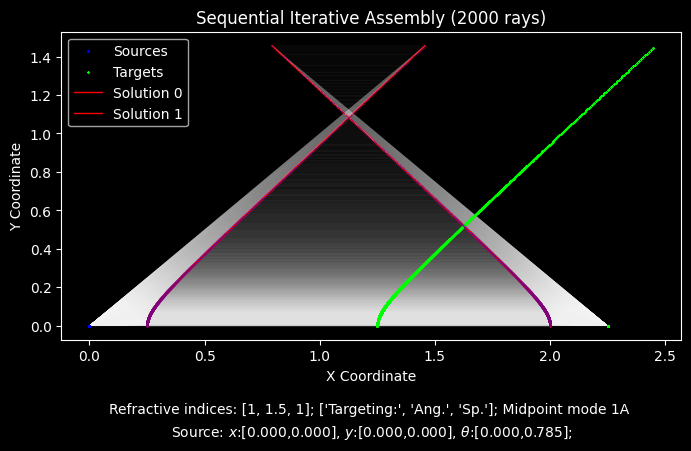

In [9]:
time_plot = time.time()

'Plotting'
plt.style.use('dark_background')
plt.figure(figsize=(8, 4))
plt.scatter(X[0], Y[0], color ='blue', label = "Sources", s=50/np.sqrt(NR), marker ="o",zorder=3)
if show_targets == True:
    plt.scatter(xT, yT, color ='lime', label = "Targets", s=50/np.sqrt(NR), marker ="x",zorder=3)
#plt.scatter(VXm, VYm, color ='magenta', label = "Midpoint vertexes", s=150, linewidth=1, marker ="+",zorder=3)
if midpoint == True:
    for s in range(0,NS):
        VXM, VXC = split(VX[s])
        VYM, VYC = split(VY[s])
        plt.plot(VX[s], VY[s], color ='red', label = f"Solution {s}", linewidth=1,zorder=1)
        plt.scatter(VXM, VYM, color ='red', s = 1/np.sqrt(NR), marker = "o", zorder=2)
        plt.scatter(VXC, VYC, color ='purple', s = 1/np.sqrt(NR), marker = "x", zorder=3)
else:
    for s in range(0,NS):
        plt.plot(VX[s], VY[s], color ='red', label = f"Solution {s}", linewidth=1,zorder=2)
        plt.scatter(VX[s], VY[s], color ='red', s = 1/np.sqrt(NR), zorder=2)

for s in range(0,NS+1):
    for i in range(0,NR):
        X_plot = [X[s][i],X[s+1][i]]
        Y_plot = [Y[s][i],Y[s+1][i]]
        plt.plot(X_plot, Y_plot, color ='white',linewidth=2/np.sqrt(NR),zorder=1)

#Fx = [X[-2][0]+F*np.cos(b),X[-2][0]+F*np.cos(b)-S*w*np.sin(b)]
#Fy = [Y[-2][0]+F*np.sin(b),Y[-2][0]+F*np.sin(b)+S*w*np.cos(b)]
#plt.plot(Fx, Fy, color ='red', label = f"Beam waist", linewidth=1,zorder=2)

closeup = False
if closeup == True:
    xmin, xmax = np.min(X[0]), np.max(X[-2])
    ymin, ymax = np.min(Y[0]), np.max(Y[-2])
    width_X = xmax-xmin
    width_Y = ymax-ymin
    plt.xlim(left=xmin-0.05*width_X,right =xmax+0.05*width_X)
    plt.ylim(bottom=ymin-0.05*width_Y,top =ymax+0.05*width_Y)
#Debug
#plt.xlim(left = -0.5, right = 2)
#plt.ylim(bottom = -0.5,top = 0.35)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'{surftxt}Iterative Assembly ({NR} rays)')
plt.legend()

xitxt = "{:.3f}".format(x_in[0])
xftxt = "{:.3f}".format(x_in[-1])
yitxt = "{:.3f}".format(y_in[0])
yftxt = "{:.3f}".format(y_in[-1])
thetaitxt = "{:.3f}".format(theta_in[0])
thetaftxt = "{:.3f}".format(theta_in[-1])

plt.text(0.5, -0.225, fr'Refractive indices: {n}; {surftypetxt}{modetxt}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, fr'Source: $x$:[{xitxt},{xftxt}], $y$:[{yitxt},{yftxt}], $\theta$:[{thetaitxt},{thetaftxt}];', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
#plt.savefig(f'{filetxt1}{filetxt2} (N={NR}) (VX0 = {VX_0}).png', dpi=200, bbox_inches='tight', transparent=False)

print("Time to plot",time.time()-time_plot,"seconds")
plt.show()

In [ ]:
import pandas as pd
from google.colab import files #For Google Colab only

In [16]:
'Export vertex data'
# Create a list to store the columns
columns = []
for s in range(NS):
    columns.append(f'VX[{s+1}]')
    columns.append(f'VY[{s+1}]')

# Create a dictionary to store data for each column
data = {}
for s in range(NS):
    data[f'VX[{s+1}]'] = VX[s]
    data[f'VY[{s+1}]'] = VY[s]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=columns)

# Export DataFrame to an Excel file
excel_file = f'{filetxt1}{filetxt2}_vertex_data.xlsx'
df.to_excel(excel_file, index=False)

# Download the Excel file
files.download(excel_file) #For Google Colab Only
print(f'Data exported to {excel_file}.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data exported to SIA-m(1A)_vertex_data.xlsx.


In [19]:
'Export the source, targets and vertex data, with split midpoints and corners'

if midpoint == True:
    corner = True #Include corners
else: #Direct mode
    corner = False

columns = ['X[0]','Y[0]']
for s in range(NS):
    if corner == True:
        columns.extend([f'VXM[{s+1}]', f'VXC[{s+1}]', f'VYM[{s+1}]', f'VYC[{s+1}]'])
    else:
        columns.extend([f'VX[{s+1}]', f'VY[{s+1}]'])
columns.extend(['Tx', 'Ty'])

data[f'X[0]'] = X[0]
data[f'Y[0]'] = Y[0]

if corner == True:
    for s in range(NS):
        VXM, VXC = split(VX[s])
        VYM, VYC = split(VY[s])
        data[f'VXM[{s+1}]'] = VXM
        data[f'VYM[{s+1}]'] = VYM
        data[f'VXC[{s+1}]'] = VXC
        data[f'VYC[{s+1}]'] = VYC
else:
    if midpoint == True:
        for s in range(NS):
            VXM, VXC = split(VX[s])
            VYM, VYC = split(VY[s])
            data[f'VX[{s+1}]'] = VXM
            data[f'VY[{s+1}]'] = VYM
    else: #Direct mode
        for s in range(NS):
            data[f'VX[{s+1}]'] = VX[s]
            data[f'VY[{s+1}]'] = VY[s]
data['Tx'] = X[-1]
data['Ty'] = Y[-1]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=columns)

# Export DataFrame to an Excel file
excel_file2 = f'{filetxt1}{filetxt2}_system_data.xlsx'
df.to_excel(excel_file2, index=False)

# Download the Excel file
files.download(excel_file2) #For Google Colab Only
print(f'Data exported to {excel_file2}.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data exported to SIA-m(1A)_system_data.xlsx.


# Code Snippets
The following code blocks can be used for some specific tests.

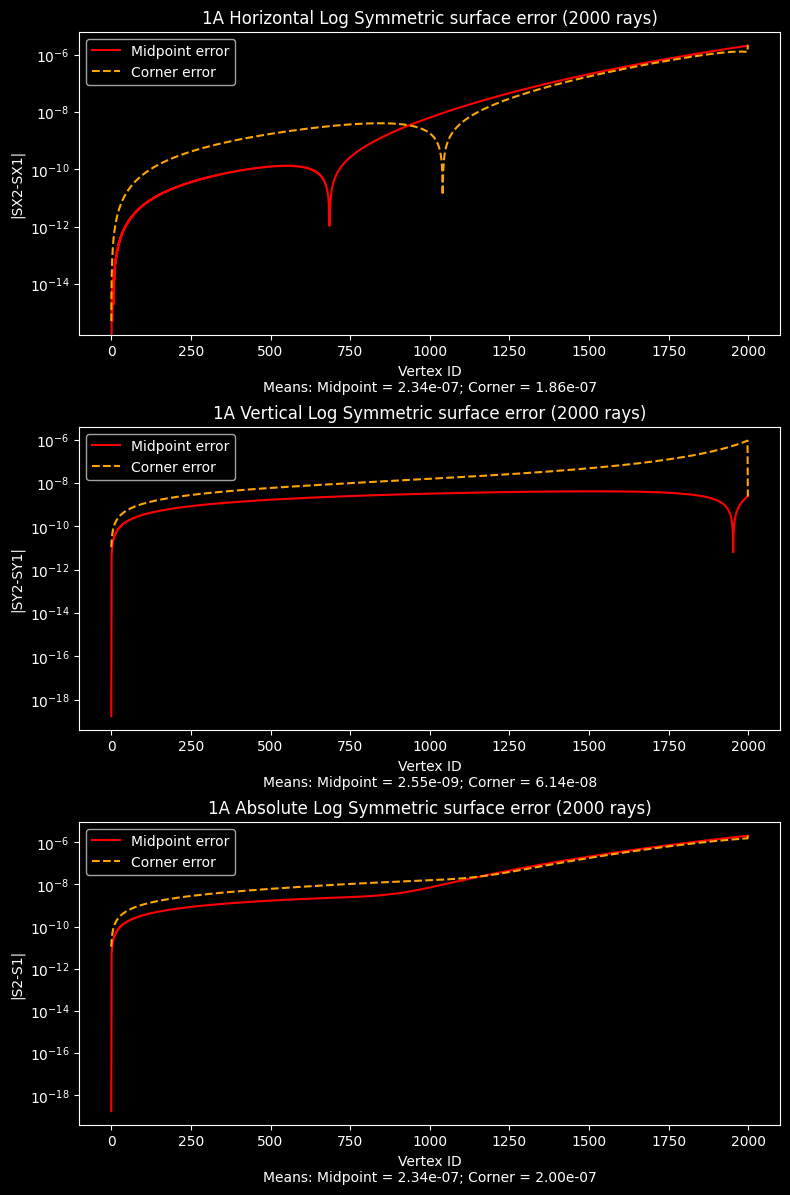

In [20]:
'Compare symmetric surfaces'
'Use this to measure relative error between successive symmetric surfaces'

step = np.linspace(0,NR,NR)

VXM1,VXC1 = split(VX[0])
VXM2,VXC2 = split(VX[1])
VYM1,VYC1 = split(VY[0])
VYM2,VYC2 = split(VY[1])

dXM, dXC, dYM, dYC, dAM, dAC = [], [], [], [], [], []

for i in range(NR):
    dXM.append(F-VXM2[i]+VX_0[1]-VXM1[i])
    dXC.append(F-VXC2[i]+VX_0[1]-VXC1[i])
    dYM.append(VYM2[i]-VYM1[i])
    dYC.append(VYC2[i]-VYC1[i])
    dAM.append(np.sqrt(dXM[-1]**2+dYM[-1]**2))
    dAC.append(np.sqrt(dXC[-1]**2+dYC[-1]**2))
MdXM = np.mean(np.abs(dXM))
MdXC = np.mean(np.abs(dXC))
MdYM = np.mean(np.abs(dYM))
MdYC = np.mean(np.abs(dYC))
MdAM = np.mean(np.abs(dAM))
MdAC = np.mean(np.abs(dAC))

MdXMs = "{:.2e}".format(MdXM)
MdXCs = "{:.2e}".format(MdXC)
MdYMs = "{:.2e}".format(MdYM)
MdYCs = "{:.2e}".format(MdYC)
MdAMs = "{:.2e}".format(MdAM)
MdACs = "{:.2e}".format(MdAC)

# Create a subplot with two rows and one column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plot for the first subplot
ax1.set_xlabel('Vertex ID')
ax1.set_ylabel('|SX2-SX1|')
ax1.set_yscale('log')
ax1.set_title(f'{modetxta} Horizontal Log Symmetric surface error ({NR} rays)')
ax1.plot(step, dXM*np.sign(dXM), color='red', label="Midpoint error")
ax1.plot(step, dXC*np.sign(dXC), color='orange', linestyle = '--', label="Corner error")
ax1.legend()
ax1.text(0.5, -0.175, fr'Means: Midpoint = {MdXMs}; Corner = {MdXCs}', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=10)

# Plot for the second subplot
ax2.set_xlabel('Vertex ID')
ax2.set_ylabel('|SY2-SY1|')
ax2.set_yscale('log')
ax2.set_title(f'{modetxta} Vertical Log Symmetric surface error ({NR} rays)')
ax2.plot(step, dYM*np.sign(dYM), color='red', label="Midpoint error")
ax2.plot(step, dYC*np.sign(dYC), color='orange', linestyle = '--', label="Corner error")
ax2.legend()
ax2.text(0.5, -0.175, fr'Means: Midpoint = {MdYMs}; Corner = {MdYCs}', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=10)


ax3.set_xlabel('Vertex ID')
ax3.set_ylabel('|S2-S1|')
ax3.set_yscale('log')
ax3.set_title(f'{modetxta} Absolute Log Symmetric surface error ({NR} rays)')
ax3.plot(step, dAM, color='red', label="Midpoint error")
ax3.plot(step, dAC, color='orange', linestyle = '--', label="Corner error")
ax3.legend()
ax3.text(0.5, -0.175, fr'Means: Midpoint = {MdAMs}; Corner = {MdACs}', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=10)

# Adjust layout
plt.tight_layout()

# Save the combined plot
#plt.savefig(f'MP ({modetxta}) Log Symmetric Error (N={NR}) (VX0 = {VX_0}, n ={n[1]}).png', dpi=200, bbox_inches='tight', transparent=False)

# Show the combined plot
plt.show()